In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.preprocessing import StandardScaler, normalize, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from scipy.sparse import csr_matrix
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
!pip install wordcloud
%matplotlib inline

In [2]:
from wordcloud import WordCloud

In [3]:
import re as rgx
import string

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB, ComplementNB

# Natural Language Tool Kit (NLTK) is a package with helpful functions for processing text
# it tends to be used by academics but is easy to implement. Other options are Gensim and SpaCy
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize 
from nltk.corpus import wordnet
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aditya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aditya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
np.random.seed= 451

# Understanding the Business Case

### 90% of consumers conisder online reviews before visiting a restaurant, making it one of the most important factors for attracting business
##### https://hbswk.hbs.edu/item/the-yelp-factor-are-consumer-reviews-good-for-business

![% of consumers who consider online reviews for restaurants](https://www.tripadvisor.com/ForRestaurants/wp-content/uploads/2018/06/28651_1_OnlineReviewsInfluenceDiningDecisions-1.png)

(not my visualization)

### Conversely, 86% of people hesitate to purchase from a business that has negative online reviews.
##### https://www.invespcro.com/online-customer-reviews.jpg

### While this project won't directly help gain more reviews or increase the number of positive reviews, highlighting existing positive reviews (and not negative ones) will likely attract more clientele

In [13]:
confuse = pd.DataFrame({'Predict Negative': ['False Negative', 'True Negative'], 'Predict Positive': ['True Positive', 'False Positive']}, index=['Positive', 'Negative'])

In [14]:
confuse.head()

,Predict Negative,Predict Positive
Positive,False Negative,True Positive
Negative,True Negative,False Positive


### Accidentally highlighting negative reviews will have a direct and negative impact on our business, so we want to minimise False Positives. 
### but we need to get a good number of True Positives as well to ensure we have enough content to work with!
### False Negatives represent unrealised potential value, but do not have a direct negative impact on the business.
### We don't really care about True Negatives.
## FP > TP > FN > TN

# Loading the dataset and EDA

In [16]:
data = pd.read_csv('train.csv', index_col='id')

In [ ]:
data.head()

,business_id,date,review_id,text,type,user_id,cool,useful,funny,class
id,,,,,,,,,,
2847,PmPOuRvuN3CoNOi1nBj_TQ,2011-09-29,oWLh_cqC97TUvRq_JjRUzw,"In town for business, and came to Pappadeaux's...",review,sgb91Hc4rVeLqehNy7Pvnw,0,1,0,1
3602,m9Wqqma30o-hH2fAX7dnug,2012-01-28,6f9pb2-bUdxlsQqJs8-cSQ,I'm on the constant hunt for good Chinese food...,review,PNS9z4aFDbfhpIsHCfNvNg,0,2,0,1
6531,TDX5Peai64ZdDvU5xHV5cQ,2011-06-06,n-suBhJOCH3mL53DvyrLPA,Jake's been taking care of our cars for almost...,review,NPoOEAPspruMOik-9sKQtQ,0,0,0,1
1301,EmlgWjs1ZzZEpDjZCSPLmw,2012-11-02,YDGhV4Lakr4TDElnwvfy2w,I am in love with the cinema suite! Being able...,review,P7Zcg73x8FzszGEiC9YPfw,0,0,0,1
3906,xczdDnDIUoVZ2ILT9nEvPA,2011-12-20,N2sauZfbLwxnbUviLo43Jw,3 kids and myself.. 14 bucks.. gotta love a Tu...,review,C6IOtaaYdLIT5fWd7ZYIuA,3,3,2,1


In [17]:
data['date'] = pd.to_datetime(data['date'])

In [ ]:
data.describe()

,cool,useful,funny,class
count,6500.000000,6500.000000,6500.000000,6500.000000
mean,0.886923,1.412615,0.706923,0.686308
std,2.151512,2.409634,1.892018,0.464029
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,1.000000
75%,1.000000,2.000000,1.000000,1.000000
max,77.000000,76.000000,39.000000,1.000000


In [ ]:
data.isna().sum()

business_id    0
date           0
review_id      0
text           0
type           0
user_id        0
cool           0
useful         0
funny          0
class          0
dtype: int64

#### No nulls or NaNs to worry about.

In [ ]:
data.isnull().sum()

business_id    0
date           0
review_id      0
text           0
type           0
user_id        0
cool           0
useful         0
funny          0
class          0
dtype: int64

## Text processing

In [35]:
# function to preprocess the text. Pass in the text column

# idea adapted from ref: https://stackoverflow.com/questions/48865150/pipeline-for-text-cleaning-processing-in-python

word_stemmer = SnowballStemmer('english') # basic stemmer, focusses on dropping suffixes with some odd effects like "has"->"ha"
stop_word_lib = stop_word_lib = stopwords.words("english")

def clean_text(text,):

    def tokenize(text):
        return [words for words in word_tokenize(text)]# for words in word_tokenize(tokens)]

    def drop_chars(text):
        tokens = tokenize(text)        
        # keeping numbers slightly improves performance 
        return ' '.join(filter(None, [rgx.sub('[^A-Za-z0-9]+', ' ', t) for t in tokens]))   

    def stem(text):
        tokens = tokenize(text)
        return ' '.join([word_stemmer.stem(t) for t in tokens])
    
    def remove_stopwords(text, stop_words=stop_word_lib):
        tokens = [word for word in tokenize(text) if word not in stop_words]
        return ' '.join(tokens)

    
    text = text.strip(' ') # strip white spaces.
    text = text.lower() # set all lower case
    text = drop_chars(text) # drop punctuation, symbols 
    text = stem(text) # stem words
    text = remove_stopwords(text) # drop stop words

    return text

In [36]:
# split the data. 

X1 = data['text'] # feature
y = data['class'] # target

X_train, X_test, y_train, y_test = train_test_split(X1,y,test_size=.2,stratify=y,random_state=451)

In [37]:
# preprocess (pp) the text in case this has not already been done
X_train_pp = X_train.apply(clean_text)
X_test_pp = X_test.apply(clean_text)

In [38]:
vct = CountVectorizer(binary=True, min_df=0.001, ngram_range=(1, 2))

### Initialising a Binary Vectorizer, which appears in a minimum of 0.001% of all reviews, with an ngram range of 1-2 words

In [39]:
vct.fit(X_train_pp, y_train)

CountVectorizer(binary=True, min_df=0.001, ngram_range=(1, 2))

In [40]:
vocab = list(vct.vocabulary_)

# EDA

In [27]:
data['year'] = data['date'].dt.year

In [28]:
counts = data.groupby('year')['class'].value_counts().unstack()
ratio = counts[1] / counts[0]

In [26]:
ratio

date
2005-04-18     NaN
2005-07-10     NaN
2005-12-16     NaN
2006-01-08     NaN
2006-01-25     NaN
              ... 
2013-01-01     3.0
2013-01-02    10.0
2013-01-03     4.0
2013-01-04     2.0
2013-01-05     NaN
Length: 1826, dtype: float64

In [128]:
data['length'] = data['text'].apply(lambda x: len(x.split()))

Text(0.5, 1.0, 'Distribution of review length by Target')

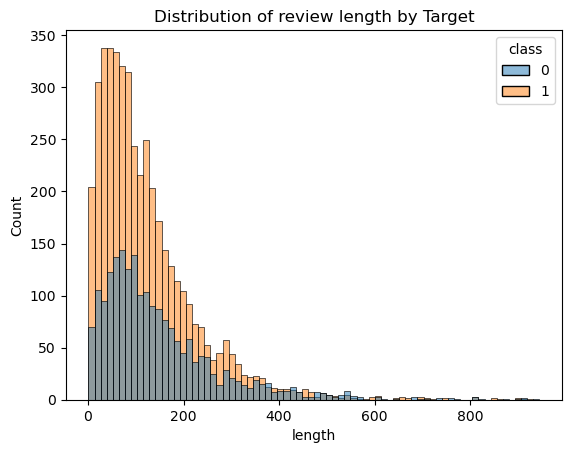

In [132]:
sns.histplot(data = data, x = 'length', hue= 'class')
plt.title('Distribution of review length by Target')

Text(0.5, 1.0, 'Ratio of Positive to Negative Reviews by Year')

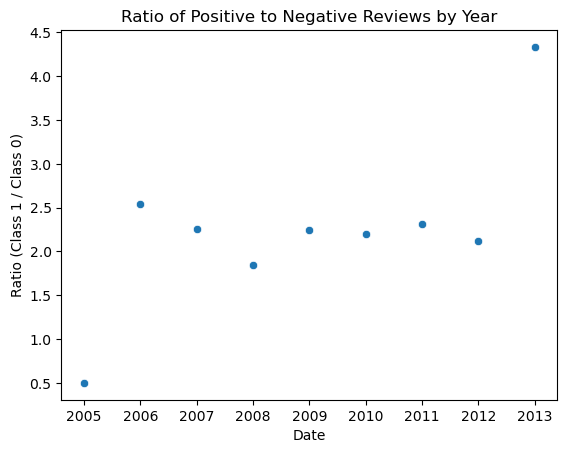

In [32]:
sns.scatterplot(data = ratio, x=ratio.index, y=ratio.values, )
plt.xlabel('Date')
plt.ylabel('Ratio (Class 1 / Class 0)')
plt.title('Ratio of Positive to Negative Reviews by Year')

<function seaborn.regression.lmplot(data=None, *, x=None, y=None, hue=None, col=None, row=None, palette=None, col_wrap=None, height=5, aspect=1, markers='o', sharex=None, sharey=None, hue_order=None, col_order=None, row_order=None, legend=True, legend_out=None, x_estimator=None, x_bins=None, x_ci='ci', scatter=True, fit_reg=True, ci=95, n_boot=1000, units=None, seed=None, order=1, logistic=False, lowess=False, robust=False, logx=False, x_partial=None, y_partial=None, truncate=True, x_jitter=None, y_jitter=None, scatter_kws=None, line_kws=None, facet_kws=None)>

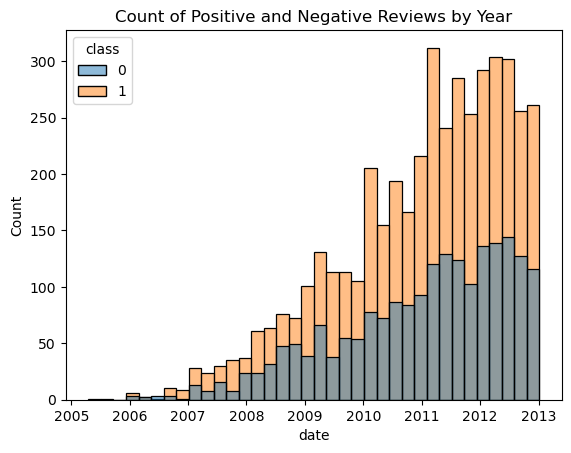

In [33]:
sns.histplot(data = data, x = 'date', hue='class')
plt.title('Count of Positive and Negative Reviews by Year')
sns.lmplot
#is there a difference in positive vs. negative reviews over time?

### Most reviews are positive but the ratio of positive to negative reviews seems to be holding fairly steady YoY

C:\Users\User\AppData\Local\Temp\ipykernel_26456\1794321463.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr())


<Axes: >

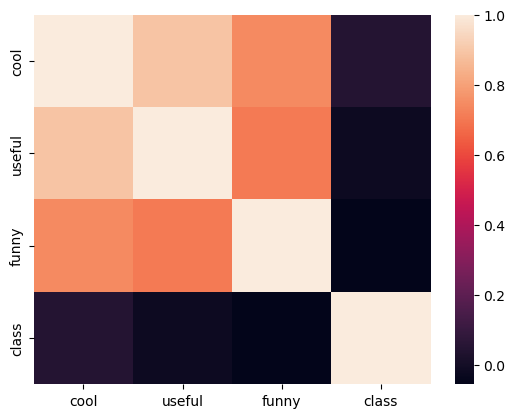

In [ ]:
sns.heatmap(data.corr())
#garbage

### The Numerical Features are pretty bad so we will stick to the word processing.

# Data Prep and Preprocessing

In [ ]:
grid_clf.best_estimator_.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('vect',
                 CountVectorizer(binary=True, min_df=0.001,
                                 ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.1))])>

### Extracting the vocabulary based on the vectorizer vocab

In [41]:
vocab_df = pd.DataFrame(vocab, index=vct.vocabulary_.values())

In [42]:
print(f'The vectoriser vocabulary contains {len(vocab)} words')

The vectoriser vocabulary contains 9289 words


In [43]:
check_df = pd.DataFrame({'text': X_train_pp, 'y_true': y_train})


In [44]:
check_df.head()

,text,y_true
id,,
9275,az 88 great experi around fun hip hop place ex...,1
7705,best ice cream sandwhich ever,1
1939,never ani complaint place except smell like de...,1
9527,experi hostess rude servic frown waiter attitu...,0
8738,recent found downtown mesa look place sit writ...,1


### Examining the frequency of the extracted vocabulary

In [ ]:
word = WordCloud().generate(' '.join(vct.vocabulary_.keys()))

(-0.5, 399.5, 199.5, -0.5)

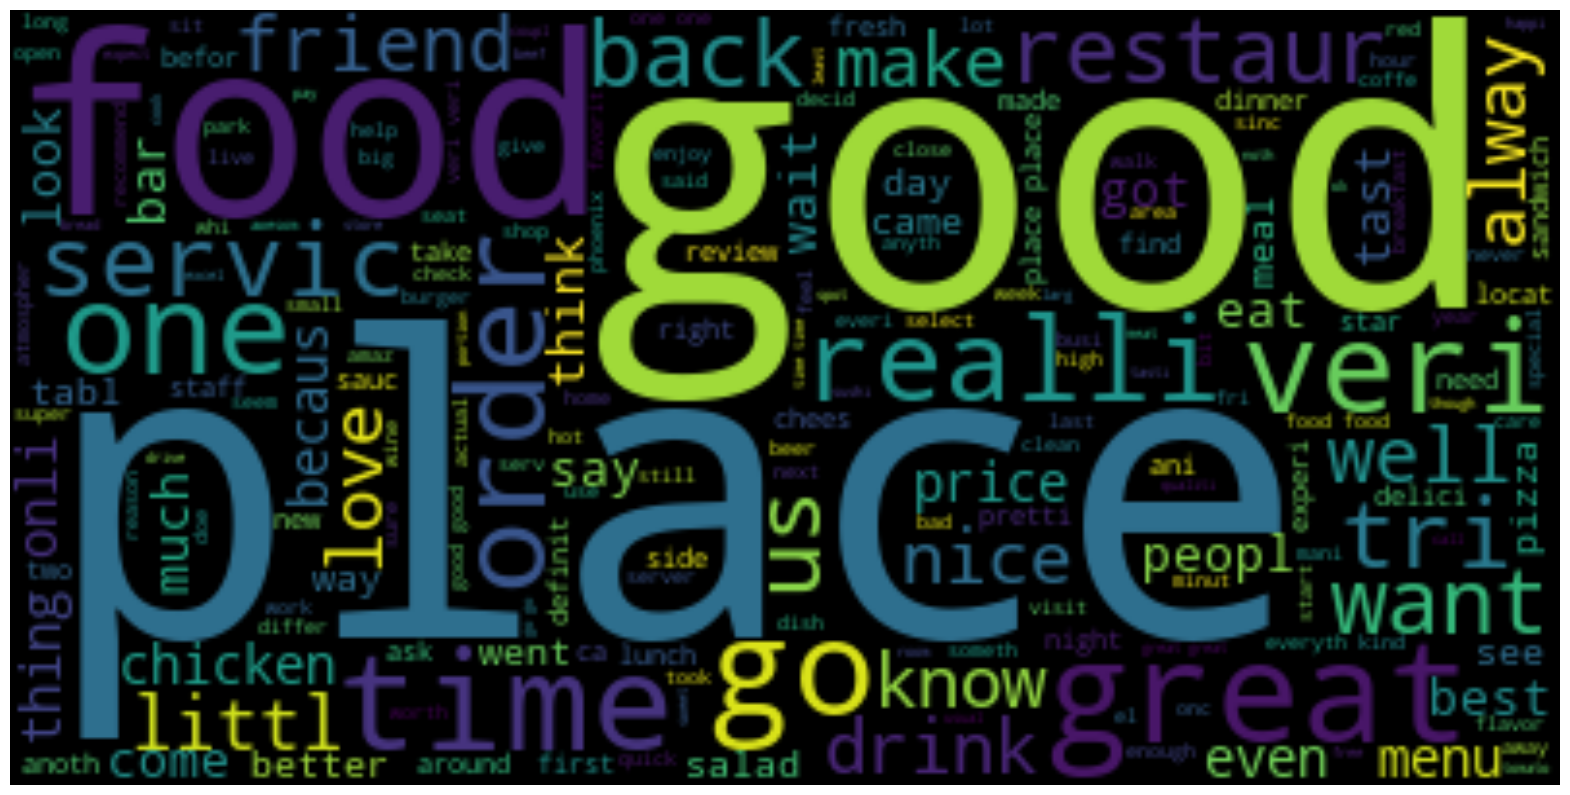

In [ ]:
plt.figure(figsize=(20, 15))
plt.imshow(word, interpolation='bilinear', )

plt.axis('off')

In [45]:
vocab_freq = {}
#Iterates through every word in vocab_df, gets the count where the text contains that word & split by y, and stores the magnitude of difference
for word in vocab_df[0]:
    freq_y0 = check_df.loc[(check_df['y_true'] == 0) & (check_df['text'].str.contains(word)), 'text'].count()
    freq_y1 = check_df.loc[(check_df['y_true'] == 1) & (check_df['text'].str.contains(word)), 'text'].count()
    diff = np.abs(freq_y0 - freq_y1)
    
    abs_diff = abs(freq_y0 - freq_y1)
    
    vocab_freq[word] = abs_diff


In [ ]:
sum(value == 0 for value in vocab_freq.values())

2105

In [ ]:
sum(value > 100 for value in vocab_freq.values())

89

Text(0.5, 1.0, 'Disparity between vocab words based on whether Class = 0 or 1')

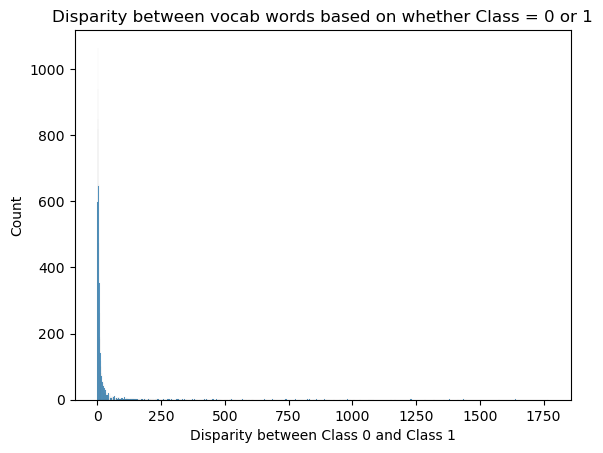

In [46]:
sns.histplot(list(vocab_freq.values()))
plt.xlabel('Disparity between Class 0 and Class 1')
plt.title('Disparity between vocab words based on whether Class = 0 or 1')

#### I tried iterating through various thresholds here: 100, 50, 25, 5. Every single one seemed to make the model worse!

In [ ]:
stop_word_lib_enh = stop_word_lib + [key for key, value in vocab_freq.items() if value <= 5]

## Creating an undersampled version of X and y with preprocessing

In [62]:
under = RandomUnderSampler(random_state=451)

In [63]:
X_res = np.array(X_train_pp).reshape(-1, 1)  # Reshape X1 to have two dimensions

In [64]:
X_train_pp_under, y_train_under = under.fit_resample(X_res, y_train)

In [ ]:
np.unique(y_train_under, return_counts= True)

(array([0, 1], dtype=int64), array([1631, 1631], dtype=int64))

In [65]:
X_train_pp_under = pd.DataFrame(X_train_pp_under).loc[:, 0]

In [ ]:
type(X_train_pp_under)

pandas.core.series.Series

# Model implementation and Grid Search

### Using a random cointoss to get a baseline model

In [ ]:
y.value_counts()

1    4461
0    2039
Name: class, dtype: int64

In [ ]:
baseline = np.random.choice([0, 1], size=6500, p=[0.31, 0.69])

In [ ]:
accuracy_score(y, baseline)

0.5586153846153846

## Pipelines

### Defining Search Space, Results grid and Parameters

In [47]:
# Define pipelines
clf = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])

lr = Pipeline([
    ('vect', CountVectorizer()), 
    ('lin', LogisticRegression(n_jobs=-1)),
])


pipelines = [clf, lr]

# Define parameter grids for each pipeline
clf_params = {
    'vect__min_df': [0.001, 0.01],
    'vect__ngram_range': [(1, 2), (1, 3)],
    'vect__binary': [True, False],
    'clf__alpha': [0.1, 5],
}

lr_params = {
    'vect__min_df': [0.001, 0.01],
    'vect__ngram_range': [(1, 2), (1, 3)],
    'vect__binary': [True, False],
    'lin__penalty': ['none', 'l2'],
    'lin__C': [1, 10, 100],
}



params = [clf_params, lr_params]

# Perform grid search for each pipeline


### Pipeline 1: Basic preprocessed text

In [48]:
results_pp = {'experiments': [], 'best_scores': [], 'best_params': [], 'best_estimator': [], 'best_probs': [], 'auc_score':[],
          'fpr':[], 'tpr':[]}

for i in range(len(pipelines)):
    grid_clf = GridSearchCV(pipelines[i], params[i], cv=5, verbose=True, n_jobs=-1)
    search_fit = grid_clf.fit(X_train_pp, y_train)
    results_pp['experiments'].append(pipelines[i].steps[-1][0])
    results_pp['best_scores'].append(search_fit.best_score_)
    results_pp['best_params'].append(search_fit.best_params_)
    results_pp['best_estimator'].append(search_fit.best_estimator_)
    
    best_est = search_fit.best_estimator_
    best_probs = best_est.predict_proba(X_test_pp)
    results_pp['best_probs'].append(best_probs[:, 1])
    results_pp['auc_score'].append(roc_auc_score(y_test, best_est.predict(X_test_pp)))
    fpr, tpr, thresholds = roc_curve(y_test, best_est.predict(X_test_pp))
    results_pp['fpr'].append(fpr)
    results_pp['tpr'].append(tpr)

# Print best scores for each pipeline



Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [126]:
grid_clf.best_params_

{'lin__C': 1,
 'lin__penalty': 'l2',
 'vect__binary': False,
 'vect__min_df': 0.001,
 'vect__ngram_range': (1, 2)}

In [ ]:
grid_clf.best_score_

0.8240384615384617

In [52]:
print(f'Accuracy score of Grid Search on preprocessed text: {accuracy_score(y_test, grid_clf.predict(X_test_pp))}')

Accuracy score of Grid Search on preprocessed text:0.833076923076923


In [55]:
print(f'Precision score of Grid Search on preprocessed text: {precision_score(y_test, grid_clf.predict(X_test_pp))}')

Precision score of Grid Search on preprocessed text: 0.8601921024546425


In [56]:
proba1 = grid_clf.predict_proba(X_test_pp)

In [57]:
proba1df = pd.DataFrame(proba1[:, 1])

In [58]:
pltx = range(len(proba1df))
plty = np.sort(proba1df, axis = 0).flatten()

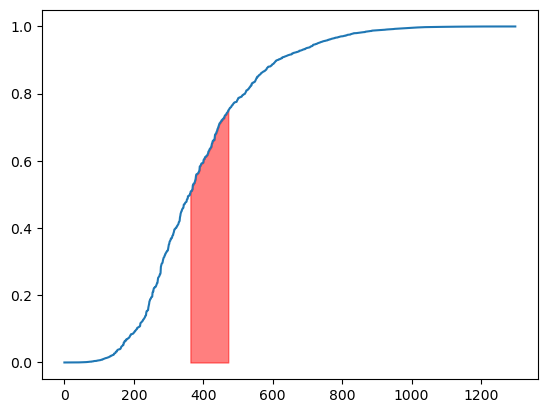

In [60]:
plt.plot(pltx, plty)
plt.fill_between(pltx, plty, where =((plty>0.5) & (plty<0.75)), color = 'red', alpha = 0.5)

### Pipeline 2: Preprocessed, undersampled text

In [66]:
results_pp_under = {'experiments': [], 'best_scores': [], 'best_params': [], 'best_estimator': [], 'best_probs': [], 'auc_score':[],
          'fpr':[], 'tpr':[]}

for i in range(len(pipelines)):
    grid_clf_under = GridSearchCV(pipelines[i], params[i], cv=5, verbose=True, n_jobs=-1)
    search_fit = grid_clf_under.fit(X_train_pp_under, y_train_under)
    results_pp_under['experiments'].append(pipelines[i].steps[-1][0])
    results_pp_under['best_scores'].append(search_fit.best_score_)
    results_pp_under['best_params'].append(search_fit.best_params_)
    results_pp_under['best_estimator'].append(search_fit.best_estimator_)
    
    best_est = search_fit.best_estimator_
    best_probs = best_est.predict_proba(X_test_pp)
    results_pp_under['best_probs'].append(best_probs[:, 1])
    results_pp_under['auc_score'].append(roc_auc_score(y_test, best_est.predict(X_test_pp)))
    fpr, tpr, thresholds = roc_curve(y_test, best_est.predict(X_test_pp))
    results_pp_under['fpr'].append(fpr)
    results_pp_under['tpr'].append(tpr)

# Print best scores for each pipeline



Fitting 5 folds for each of 16 candidates, totalling 80 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [127]:
grid_clf_under.best_params_

{'lin__C': 1,
 'lin__penalty': 'l2',
 'vect__binary': True,
 'vect__min_df': 0.001,
 'vect__ngram_range': (1, 2)}

### With the undersampled model, we find that the best result comes from a Binarised vectoriser, which is not the case for the basic preprocessed model. Interesting!

In [68]:
print(f'Accuracy score of Grid Search on preprocessed + Undersampled text: {accuracy_score(y_test, grid_clf_under.predict(X_test_pp))}')


Accuracy score of Grid Search on preprocessed + Undersampled text: 0.7984615384615384


In [69]:
print(f'Precision score of Grid Search on preprocessed + Undersampled text: {precision_score(y_test, grid_clf_under.predict(X_test_pp))}')


Precision score of Grid Search on preprocessed + Undersampled text: 0.8888888888888888


## Artificially enforcing a harsher threshold for positive predictions

In [70]:
proba_under = grid_clf_under.predict_proba(X_test_pp)

In [71]:
proba_under_df  = pd.DataFrame(proba_under[:, 1])

In [72]:
pltx1 = range(len(proba_under_df))
plty1 = np.sort(proba_under_df, axis = 0).flatten()

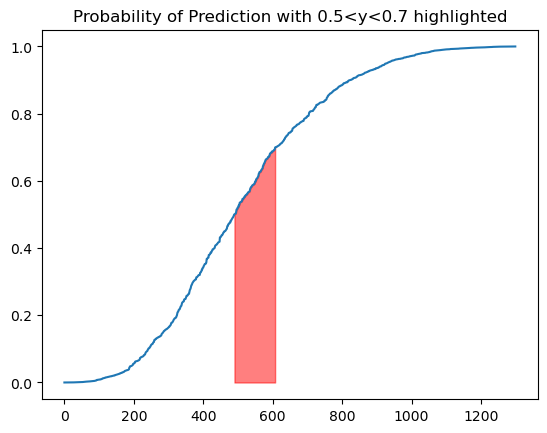

In [87]:
plt.plot(pltx1, plty1)
plt.title('Probability of Prediction with 0.5<y<0.7 highlighted')
plt.fill_between(pltx1, plty1, where =((plty1>0.5) & (plty1<0.7)), color = 'red', alpha = 0.5)

In [83]:
hipreds_2 = [] 
for x in proba_under_df.values[:, 0]:
    if x>0.7:
        hipreds_2.append(1)
    elif x<=0.85:
        hipreds_2.append(0)

In [84]:
print(f'Accuracy score of Grid Search on preprocessed + Undersampled text with harsh threshold: {accuracy_score(y_test, hipreds_2)}')



Accuracy score of Grid Search on preprocessed + Undersampled text with harsh threshold: 0.7615384615384615


In [85]:
print(f'Precision score of Grid Search on preprocessed + Undersampled text with harsh threshold: {precision_score(y_test, hipreds_2)}')



Precision score of Grid Search on preprocessed + Undersampled text with harsh threshold: 0.9205202312138728


# Validating the results and generating predictions

In [88]:
test_true =pd.read_csv('test.csv')

In [89]:
X_val = test_true['text']

In [90]:
X_val_pp = X_val.apply(clean_text)

Text(0.19, 0.02, 'Precision = 0.8601921024546425')

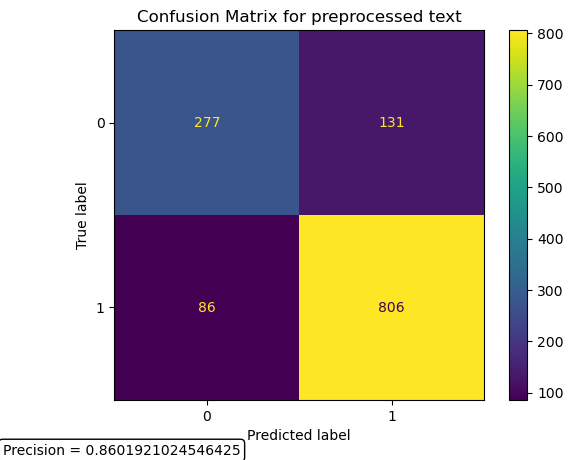

In [113]:
ConfusionMatrixDisplay(confusion_matrix(y_test, grid_clf.predict(X_test_pp))).plot()
plt.title(f'Confusion Matrix for preprocessed text')
plt.annotate(f'Precision = {precision_score(y_test, grid_clf.predict(X_test_pp))}', xy = (0.19, 0.02), xycoords='figure fraction', fontsize=10,
            ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white'))

In [ ]:
131/(131+277)

0.32107843137254904

Text(0.19, 0.02, 'Precision = 0.8888888888888888')

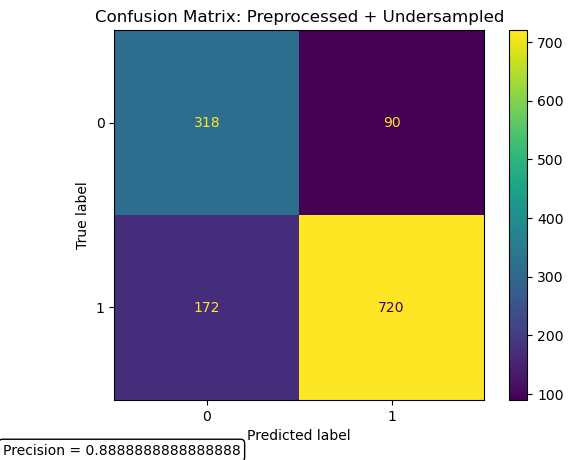

In [114]:
ConfusionMatrixDisplay(confusion_matrix(y_test, grid_clf_under.predict(X_test_pp))).plot()
plt.title(f'Confusion Matrix: Preprocessed + Undersampled')
plt.annotate(f'Precision = {precision_score(y_test, grid_clf_under.predict(X_test_pp))}', xy = (0.19, 0.02), xycoords='figure fraction', fontsize=10,
            ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white'))

In [ ]:
90/(90+318)

0.22058823529411764

Text(0.19, 0.02, 'Precision = 0.9205202312138728')

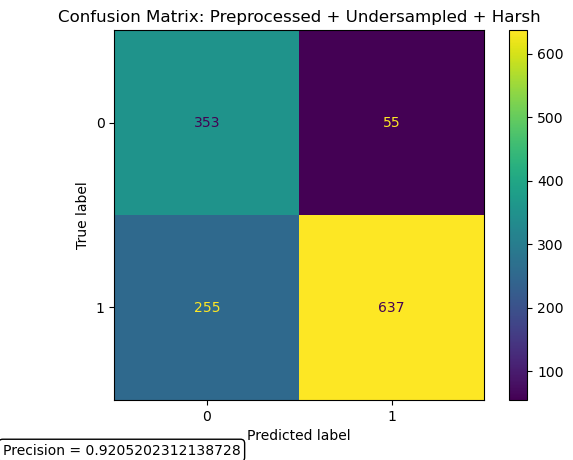

In [115]:
ConfusionMatrixDisplay(confusion_matrix(y_test, hipreds_2)).plot()
plt.title(f'Confusion Matrix: Preprocessed + Undersampled + Harsh')
plt.annotate(f'Precision = {precision_score(y_test, hipreds_2)}', xy = (0.19, 0.02), xycoords='figure fraction', fontsize=10,
            ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white'))

In [ ]:
49/(49+359)

0.12009803921568628

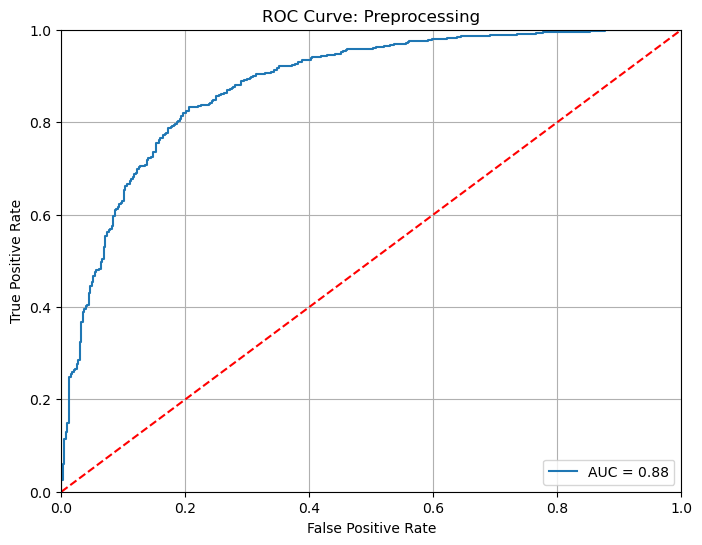

In [116]:
# Get the predicted probabilities for the test set
y_pred_prob = grid_clf.best_estimator_.predict_proba(X_test_pp)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'r--')  # Random guessing line
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Preprocessing')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

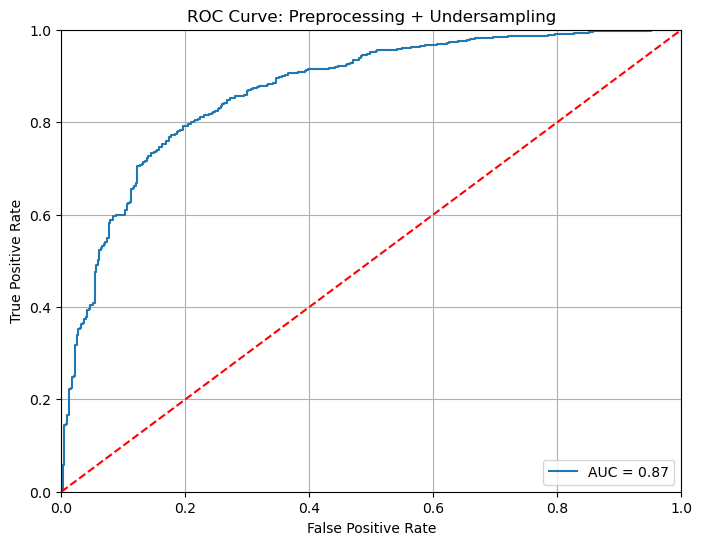

In [117]:
# Get the predicted probabilities for the test set
y_pred_prob = grid_clf_under.best_estimator_.predict_proba(X_test_pp)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'r--')  # Random guessing line
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Preprocessing + Undersampling')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [119]:
y_pred_prob_hi = []

In [120]:
for x in y_pred_prob:
    if x>0.5 and x<0.7:
        y_pred_prob_hi.append(0.49)
    else:
        y_pred_prob_hi.append(x)
    

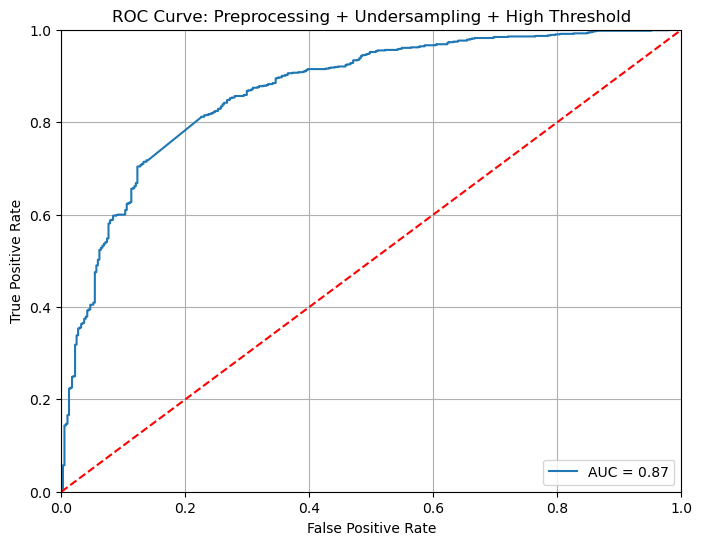

In [122]:
# Get the predicted probabilities for the test set


# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_hi)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_prob_hi)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'r--')  # Random guessing line
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Preprocessing + Undersampling + High Threshold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
data_val = pd.read_csv('test.csv')

In [ ]:
X_val = data_val['text']

In [ ]:
X_val_pp = X_val.apply(clean_text)

In [ ]:
X_val_pp_enh = X_val.apply(clean_text_enh)

In [ ]:
results = pd.DataFrame({'id': data_val['id'], 'class': grid_clf.predict(X_val_pp)})



In [ ]:
results.to_csv('results.csv')